# ** Camera Calibration and Image Undistortion**


**Recommended** [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

and for presenting:

````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

In [1]:
%pylab inline
import cv2
import glob

Populating the interactive namespace from numpy and matplotlib


---

- In this notebook we'll briefly cover **intrinsic camera calibration** and **image undistortion**. 
- These methods go hand-in-hand, and are important whenever we need to mathematically relate 2d images to the 3d scenes they represent. 
- Most the of code shown here is taken from this  [opencv calibration tutorial](https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html). 
- The opencv [Camera Calibration and 3d Reconstruction Documentation](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html) is very helpful here as well. 

![](../graphics/spacer_small-01.png)

## **The Intrinsic Matrix is Important**

![](../graphics/equation_summary-01.png)

- In our discussion of the pinhole camera model, we discussed the intrinsic matrix $\Lambda$, which allowed us to project points in world space to points in image space. 
- And, we even went so far as to estimate $\Lambda$ for a specific camera, using the focal length, field of view, and resolution from the camera spec sheet. 
- Now, for many important problems, we'll need a better estimate of $\Lambda$ than the one we obtain from the specification. 
- In practice, a number of factors may contribute inaccuracies to our theoritical $\Lambda$, such as the image sensor not being perfectly aligned with out camera lens.
- Fortunately, there are robust algorithmic methods to compute more accurate estimates of $\Lambda$, from images alone. 

![](../graphics/spacer_small-01.png)

## **But there's one more problem we need to address**

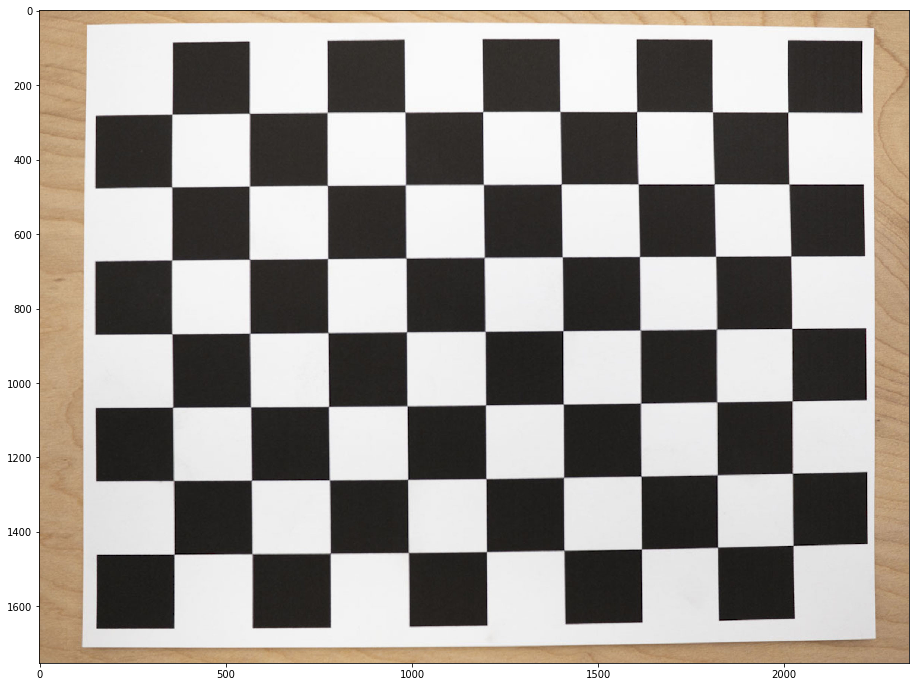

In [2]:
img = cv2.imread('../data/other_chessboards/chessboard_0001.JPG')

fig = figure(0, (18,12))
imshow(img[:,:,(2,1,0)]) #Switch blue and red channel for visualization (have to do this because we imported with opencv))

- Here's an image of a chessboard I took with my panasonic gh4. 
- **Does anything look off to you?**

---

![](../graphics/spacer_small-01.png)

- If you look carefully at the edges of the chessboard, they might appear bowed or curved outward. 
- This is a result of **light bending** as it passes through the lens of our camera. 
- This effect is most obvious when using wide angle lenses, such as those on Go Pro cameras. 
- This **bending of light** through our lens in imprortant, becuase it means that...

## **The Pinhole Camera Model is Wrong**

![](../graphics/prince/InverseImaging.jpg)

- One of the first assumptions we made when developing the pinhole camera model is that the light rays passed from the world into our camera followed **straight line paths**.
- Out light bending through our lens means that **our pinhole camera model is wrong**.
- Now, fortunately, there are well developed methods for modeling the bending of light through our lens. 
- Using these models, we can remove the effect of lens distortion, allowing us to use our pinhole camera model with a high degree of accuracy. 

## **Modeling Lens Distortion**

- We'll use opencv to model lens distortion
- Opencv's built in methods use 5 parameters to model lens distortion and break distortion into radial and tangential components
- Here's how opencv remaps pixels to model lens distortion:

\begin{array}{rlcccc}
x' &= x &+ &\underbrace{x(k_1 r^2 + k_2 r^4 + k_3 r^6)} &+ &\underbrace{2 p_1 x y + p_2(r^2 + 2 x^2)}\\
&= x &+ &\Delta x_{radial} &+ &\Delta x_{tangential}
\end{array}


\begin{array}{rlcccc}
y' &= y &+ &\underbrace{y(k_1 r^2 + k_2 r^4 + k_3 r^6)} &+ &\underbrace{2 p_2 x y + p_1(r^2 + 2 y^2)}\\
&= y &+ &\Delta y_{radial} &+ &\Delta y_{tangential}
\end{array}

- Check out the docs for more details [Camera Calibration and 3d Reconstruction Documentation](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- That that opencv can support up to 8 distortion parameters - the simpler 5 parameter model is shown above (the opencv 8 paramter model is identical to the quations above when $k_4, k_5, k_6 = 0$.
- Let's get a sense for what these paramters do:

![](../videos/distortion_animation.gif)

---

- So, as you can imagine, some combination of these 5 parameters should allow us to correct for the distortion/bending of light cuased by our lens. 
- So far we've discussed 2 problems: 



1. Accurately estimating our intrinsic matrix $\Lambda$
2. Estimating our distortion parameters ${k_1, k_2, k_3, p_1, p_2}$

- Since our intrinsic matrix depends on our pinhole camera model, which does not take into account lens distortion, we may need to estimate our distortion parameters first or perhaps estimate both unkowns concurently. 
- We'll use opencv's [calibrateCamera](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#calibratecamera) method, which simultaneously estimates our intrinsic matrix and distortion parameters. 
- Remarkably, using [Zhang's Algorithm](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.220.534&rep=rep1&type=pdf), opencv is able to estimate our intrinsic matrix and distortion coefficient **only using images of chessboards**.

## **The Camera**

![](../graphics/panasonic_gh4-01.png)

## ** The Data**

In [3]:
%pylab inline
import cv2
import glob

Populating the interactive namespace from numpy and matplotlib


In [4]:
filenames = glob.glob('../data/chessboards/*.JPG')

In [5]:
len(filenames)

25

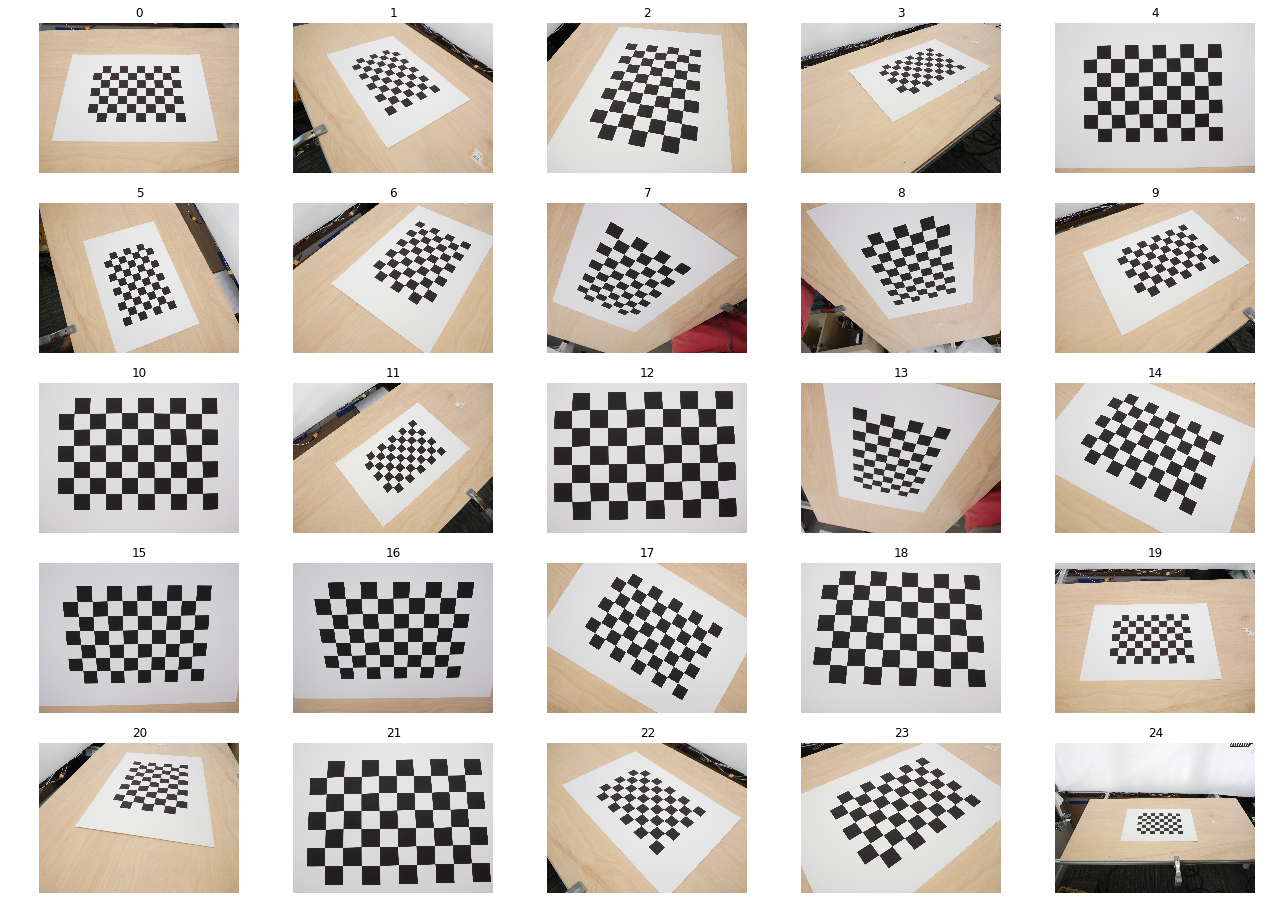

In [6]:
fig = figure(0, (22,16))
for i in range(len(filenames)):
    fig.add_subplot(5,5,i+1)
    img = cv2.imread(filenames[i])
    imshow(img[:,:,(2,1,0)], cmap = 'gray')
    axis('off')
    title(i)

---

## The opencv Pipeline

In [7]:
i = 11
img = cv2.imread(filenames[i])

In [8]:
img.shape

(1752, 2336, 3)

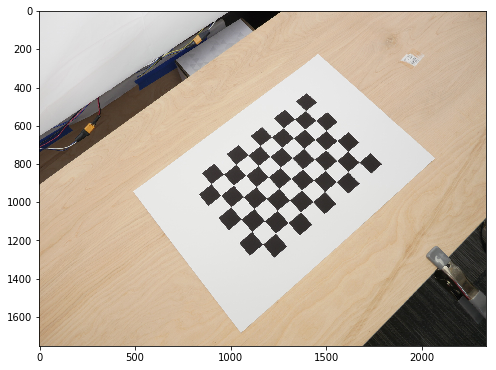

In [9]:
fig = figure(0, (8, 12))
imshow(img[:,:,(2,1,0)])

- Notice that our chessboard has 9 interior corners in one dimension and 7 in the other.
- Before running `cv2.calibrateCamera`, we need to find the corners of our chessboard
- opencv has nice method to help use her:

In [10]:
#Conver to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Find the chess board corners
ret, corners = cv2.findChessboardCorners(image = gray, patternSize = (6,9), corners = None)

In [11]:
ret

True

In [12]:
corners.shape

(54, 1, 2)

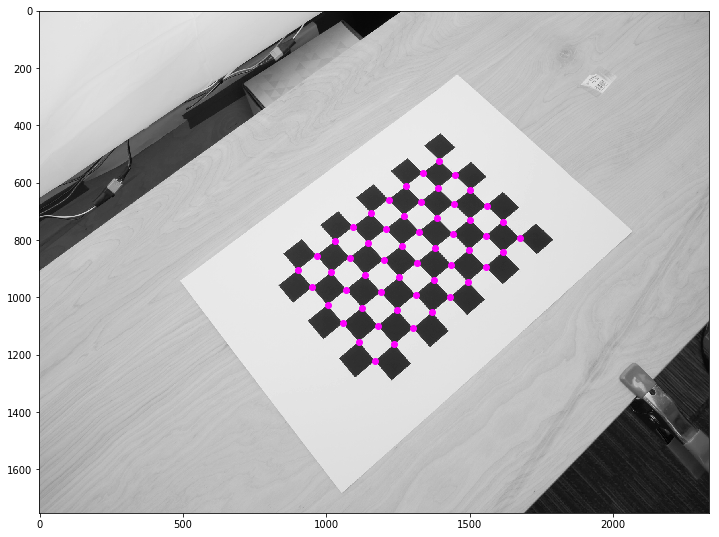

In [13]:
fig = figure(0, (12,12))
imshow(gray, cmap = 'gray')
scatter(corners[:,0,0], corners[:,0,1], color = (1, 0, 1))

- Pretty Good, right?
- Now we'll iterate through our images, and extract corners for each.

In [14]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# These object points or "world coordinates" are in the coordinate frame of 
# the chessboard, so they won't change image to image. 
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
   
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Save images for visualization:
images = []
images_fail = []

In [15]:
for filename in filenames:
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Find the chess board corners
    ret, corners = cv2.findChessboardCorners(image = gray, patternSize = (6,9), corners = None)
    
    if ret:
        objpoints.append(objp)
        cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),criteria)
        imgpoints.append(corners)   
        
        #For visualization
        images.append(gray)
        
    else:
        images_fail.append(gray)

In [16]:
len(images)

25

In [17]:
len(images_fail)

0

Let's visualize our successful detections.

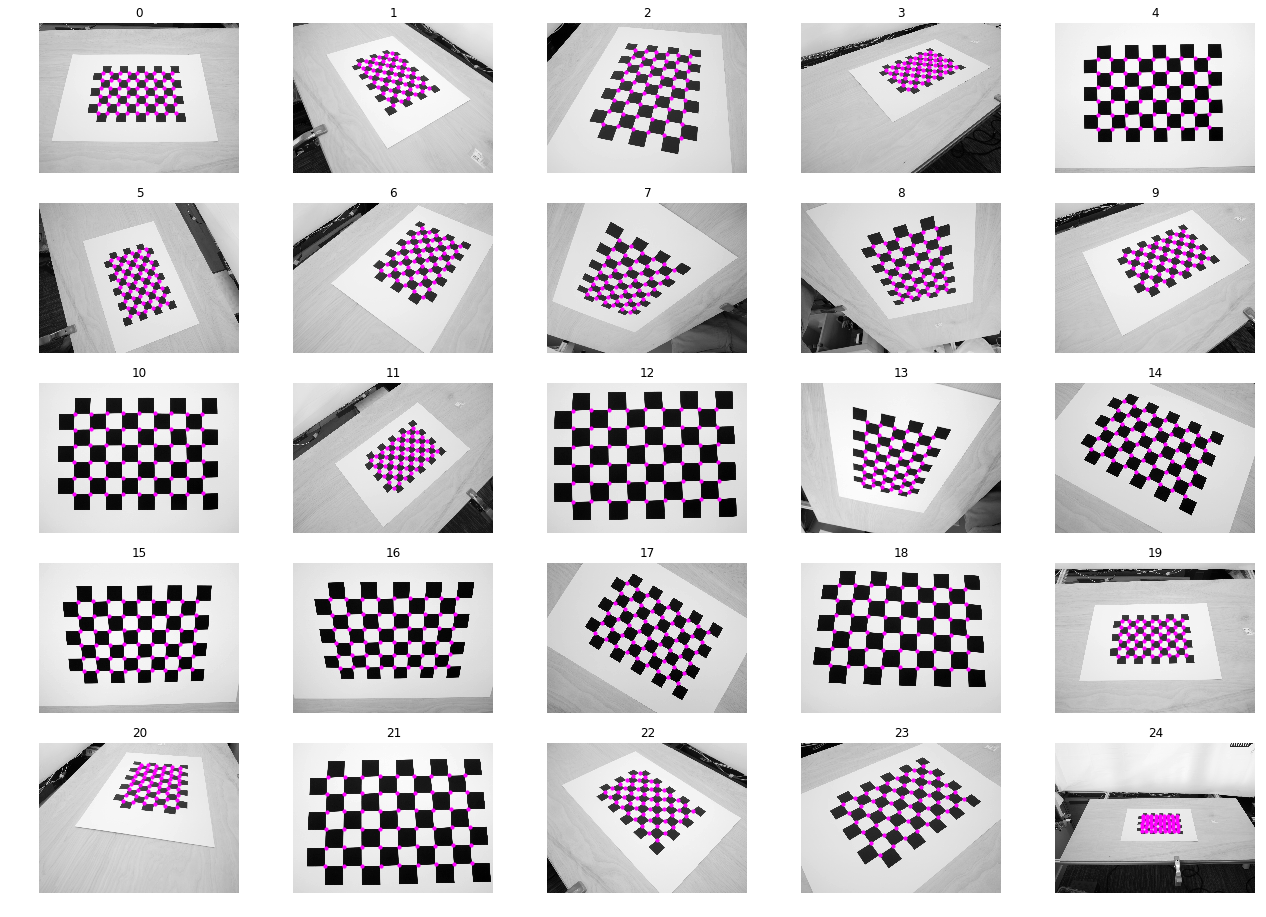

In [18]:
fig = figure(0, (22,16))
for i in range(len(images)):
    fig.add_subplot(5,5,i+1)
    imshow(images[i], cmap = 'gray')
    scatter(imgpoints[i][:,0,0], imgpoints[i][:,0,1], color = (1, 0, 1), s = 10)
    axis('off')
    title(i)

## **Calibration Time**

- Alright, now using the image points we detected in our images, and our object points, we can now calibrate!

In [19]:
ret, intrinsicP, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                          imgpoints, 
                                                          gray.shape[::-1],
                                                          None,
                                                          None)

In [20]:
#Intrinsic Matrix
intrinsicP

array([[2.00341660e+03, 0.00000000e+00, 1.16131997e+03],
       [0.00000000e+00, 2.00272450e+03, 8.58103686e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [21]:
#Distortion Coeffcients!
dist

array([[-3.84855054e-02, -1.36252468e-01, -3.64403728e-04,
        -9.74357426e-05,  3.70726423e-01]])

## **Now, do our results make any sense?**

- Let's have a look at our results and see if our calibration appears to have worked. 
- Let's start with our intrinsic matrix.
- Let's briefly review the various pieces of our instinsic matrix from our pinhole camera model discussion.

---

![](../graphics/intrinsic_matrix_overview-01.png)

In [22]:
intrinsicP

array([[2.00341660e+03, 0.00000000e+00, 1.16131997e+03],
       [0.00000000e+00, 2.00272450e+03, 8.58103686e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

- Does our intrinsic matrix make sense?
- How well aligned are our image sensor and principle point?
- Using the camera specifications above, does the focal length in spec sheet match the focal length computed from our intrinsic matrix (also using our pixel spacing from the spec sheet)? 

---

![](../graphics/spacer_small-01.png)

# **Image Undistortion**

- Now let's have a look at our image distortion parameters. 
- The best way to see if these makes sense is to undistort our chessboard images and see if the results appear more square.

In [23]:
dist

array([[-3.84855054e-02, -1.36252468e-01, -3.64403728e-04,
        -9.74357426e-05,  3.70726423e-01]])

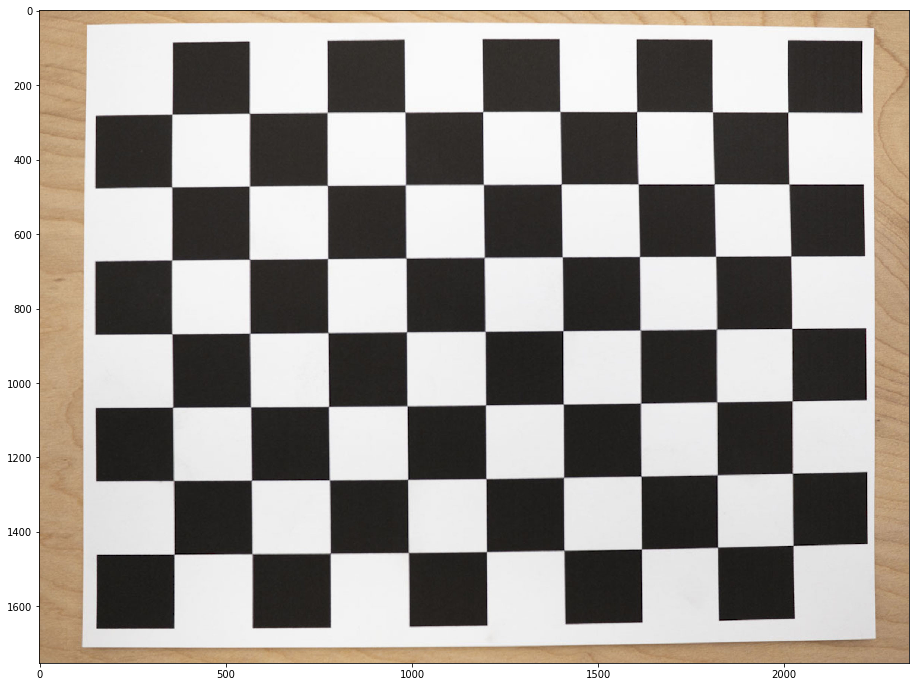

In [24]:
img = cv2.imread('../data/other_chessboards/chessboard_0001.JPG')
fig = figure(0, (18,12))
imshow(img[:,:,(2,1,0)])

We'll use the opencv `undistort` method.

In [25]:
undistorted = cv2.undistort(img, intrinsicP, distCoeffs = dist)

Text(0.5,1,'distorted, undistorted')

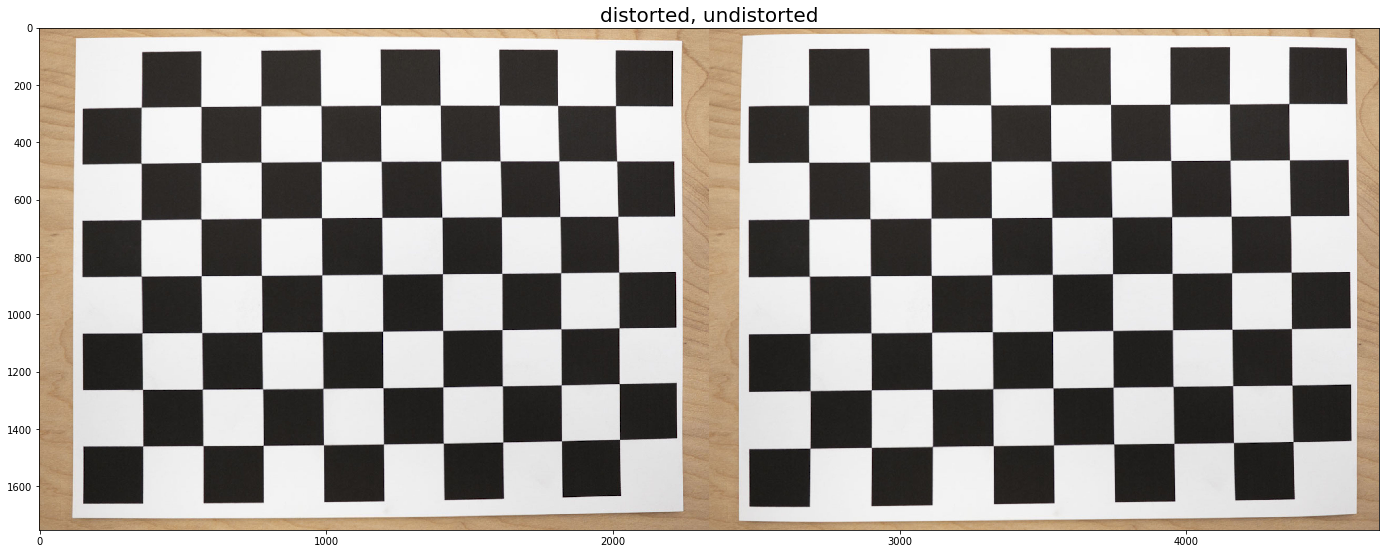

In [26]:
side_by_side = np.hstack((img, undistorted))

fig = figure(0, (24,12))
imshow(side_by_side[:,:,(2,1,0)])
title('distorted, undistorted', fontsize = 20)

- It's a little hard to see in this example, but the lines in the undistorted image are straighter!
- Now, here's the really nice outcome:

## If we use undistorted images, our **pinhole camera model** is valid again!

- Undistorting our images allows to ignore the messy non-linearities of lens distortion. 

![](../graphics/spacer_small-01.png)

## Appendix A

Undistoring some image for use elsewhere in this module.

In [40]:
img = cv2.imread('../data/grids/grid_1.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
undistorted = cv2.undistort(img, intrinsicP, distCoeffs = dist)

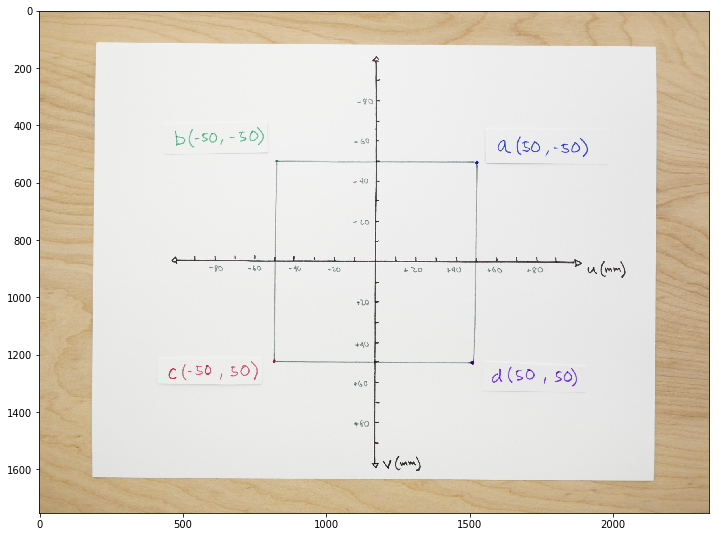

In [41]:
fig = figure(0, (12,12))
imshow(undistorted[:,:,(2,1,0)])

In [42]:
cv2.imwrite('../data/grids/grid_1_undistorted.jpg', undistorted)

True

In [43]:
img = cv2.imread('../data/grids/grid_2.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
undistorted = cv2.undistort(img, intrinsicP, distCoeffs = dist)
cv2.imwrite('../data/grids/grid_2_undistorted.jpg', undistorted)

True

In [44]:
img = cv2.imread('../data/grids/grid_3.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
undistorted = cv2.undistort(img, intrinsicP, distCoeffs = dist)
cv2.imwrite('../data/grids/grid_3_undistorted.jpg', undistorted)

True